<a href="https://colab.research.google.com/github/moliver813/Data_Science_Miniprojects/blob/main/Diffuser_MNIST_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Model for MNIST digits

Trying the diffusion model from the DataCamp webinar (https://www.youtube.com/watch?v=mMNYK5o4dnI&ab_channel=DataCamp), but on the MNIST digits data set instead.

In [ ]:
!pip install torchmultimodal-nightly



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.3/256.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.9 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=12ce86ffec9fb5c6dcb474482f34f908d79affba5d60a8a0fae7d8ef02518534
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath


In [ ]:
import torch
import torchvision
import torchvision.transforms.functional as F

from torch import nn
from tqdm import tqdm
from torchmultimodal.diffusion_labs.modules.adapters.cfguidance import CFGuidance
from torchmultimodal.diffusion_labs.modules.losses.diffusion_hybrid_loss import DiffusionHybridLoss
from torchmultimodal.diffusion_labs.samplers.ddpm import DDPModule
from torchmultimodal.diffusion_labs.predictors.noise_predictor import NoisePredictor
from torchmultimodal.diffusion_labs.schedules.discrete_gaussian_schedule import linear_beta_schedule, DiscreteGaussianSchedule
from torchmultimodal.diffusion_labs.transforms.diffusion_transform import RandomDiffusionSteps
from torchmultimodal.diffusion_labs.utils.common import DiffusionOutput

# Schedule

In [ ]:
# Define Diffusion Schedule

schedule = DiscreteGaussianSchedule(linear_beta_schedule(1000))


# Predictor

In [ ]:
# Define Prediction Target

predictor = NoisePredictor(schedule, lambda x : torch.clamp(x,-1,1))

# UNet

In [ ]:
# Down scaling input blocks for unet
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()
        # Define convolutions
        self.block = nn.Sequential(
            nn.Conv2d(in_channels + cond_channels, out_channels, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU()
        )


        self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, c):
        _, _, w, h = x.size()
        c = c.expand(-1, -1, w, h)              # Shape conditional input to match image
        x = self.block(torch.cat([x, c], 1))    # Convolutions over image + condition
        x_small = self.pooling(x)               # Downsample output for next block
        return x, x_small

# Upscaling blocks on unet
class UpBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.block = nn.Sequential(
            # 2 * inp because we will be adding input from two sources
            nn.Conv2d(2*inp, out, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(out,out,kernel_size=3,padding=1),
            nn.ReLU()
        )

        #Define convolutions
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, x_small):
        x_big = self.upsample(x_small)          # Upscale input back towards original size
        x = torch.cat((x_big, x), dim=1)        # Join previous block with accross block
        x = self.block(x)                       # Convolutions over image
        return x

class UNet(nn.Module):
    def __init__(self, time_size=32, digit_size=28, steps=1000):
        super().__init__()
        cond_size = time_size + digit_size
        # Define UNet
        self.conv = nn.Conv2d(1,128,kernel_size=3,padding=1)
        # arbitrary numbers
        self.down = nn.ModuleList([DownBlock(128,256,cond_size),DownBlock(256,512,cond_size)])
        # can use a different achitecture for the bottleneck, but let's use downblock
        self.bottleneck = DownBlock(512,512,cond_size)
        self.up   = nn.ModuleList([UpBlock(512,256),UpBlock(256,128)])

        self.variance   = nn.Conv2d(128,1,kernel_size=3,padding=1)
        self.prediction = nn.Conv2d(128,1,kernel_size=3,padding=1)
        self.time_projection  = nn.Embedding(steps,time_size)

    def forward(self, x, t, conditional_inputs):
        b,c,h,w = x.shape
        # every pixel in the time series gets each pixel added
        timestep = self.time_projection(t).view(b,-1,1,1)
        condition = conditional_inputs['context'].view(b,-1,1,1)
        condition = torch.cat([timestep,condition],dim=1)

        # Define forward
        x = self.conv(x)
        outs = []
        for block in self.down:
            out, x = block(x,condition)
            outs.append(out)
        x,_ = self.bottleneck(x,condition)
        for block in self.up:
            x = block(outs.pop(), x)
            #temp = outs.pop()
            #print(f"Debug: shapes: out: {temp.shape}, x : {x.shape} ")

        # variance is optional, but helps with the training
        v = self.variance(x)
        p = self.prediction(x)
        # diffusion output expects prediction and variance
        return DiffusionOutput(p,v)




In [ ]:
unet = UNet(time_size=28, digit_size=32)
# Add support for classifier free guidance
unet = CFGuidance(unet, {"context":32}, guidance = 2.0)

In [ ]:
# Define evalution
# can skip some steps, and the model will still learn well
eval_steps = torch.linspace(0,999,250,dtype = torch.long) # do only every 4th step
model = DDPModule(unet, schedule, predictor,eval_steps)

In [ ]:
# Define conditional embeddings
# Larger models use LLMs
# simpler model, based on the fact that the data set has 10 classes
encoder = nn.Embedding(10,32)

# Data

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Lambda

# Transform data and use RandomDiffusionSteps to sample random noise
diffusion_transform = RandomDiffusionSteps(schedule, batched=False)
transform = Compose([
    Resize(28),
    ToTensor(), # format from PIL to PyTorch
    Lambda(lambda x: 2*x - 1), # don't want images in 0-1, because we add noise in -1,1. Choose -1,1
    Lambda(lambda x: diffusion_transform({"x":x}))
])

In [ ]:

from torch.utils.data import DataLoader

# torchvision.datasets.MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
mnist_set = torchvision.datasets.MNIST(root="data_train",train=True,download=True,transform=transform)


# Data Loader
batch_size = 32
train_dataloader = DataLoader(dataset=mnist_set,batch_size=batch_size,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 277225005.13it/s]

Extracting data_train/MNIST/raw/train-images-idx3-ubyte.gz to data_train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103446365.35it/s]


Extracting data_train/MNIST/raw/train-labels-idx1-ubyte.gz to data_train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67543278.74it/s]

Extracting data_train/MNIST/raw/t10k-images-idx3-ubyte.gz to data_train/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6628576.47it/s]


Extracting data_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_train/MNIST/raw



# Train

In [ ]:
epochs = 15

device = "cpu"

# modification to use GPU
# Check the device information
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


encoder.to(device)
model.to(device)

# Apply optimizer to diffusion model and encoder for joint training
optimizer = torch.optim.AdamW(
    [{"params": encoder.parameters()}, {"params": model.parameters()}], lr=0.0001
)
# Define loss
h_loss = DiffusionHybridLoss(schedule)

encoder.train()
model.train()
for e in range(epochs):
    for sample in (pbar := tqdm(train_dataloader)):
        x, c = sample
        x0, xt, noise, t, c = x["x"].to(device), x["xt"].to(device), x["noise"].to(device), x["t"].to(device), c.to(device)
        optimizer.zero_grad()
        # Compute loss
        embedding = encoder(c)
        out = model(xt,t,{"context":embedding})
        loss = h_loss(out.prediction,noise,out.mean,out.log_variance,x0,xt,t)

        loss.backward()
        optimizer.step()

        pbar.set_description(f'{e+1}| Loss: {loss.item()}')

Using cuda device


1| Loss: 0.04089619591832161: 100%|██████████| 1875/1875 [01:33<00:00, 20.11it/s]
2| Loss: 0.0345332995057106: 100%|██████████| 1875/1875 [01:32<00:00, 20.25it/s]
3| Loss: 0.03385421633720398: 100%|██████████| 1875/1875 [01:32<00:00, 20.35it/s]
4| Loss: 0.021185023710131645: 100%|██████████| 1875/1875 [01:32<00:00, 20.32it/s]
5| Loss: 0.018404467031359673: 100%|██████████| 1875/1875 [01:34<00:00, 19.94it/s]
6| Loss: 0.02154298685491085: 100%|██████████| 1875/1875 [01:32<00:00, 20.35it/s]
7| Loss: 0.027122924104332924: 100%|██████████| 1875/1875 [01:34<00:00, 19.87it/s]
8| Loss: 0.026640724390745163: 100%|██████████| 1875/1875 [01:32<00:00, 20.19it/s]
9| Loss: 0.031375400722026825: 100%|██████████| 1875/1875 [01:33<00:00, 19.97it/s]
10| Loss: 0.025506284087896347: 100%|██████████| 1875/1875 [01:36<00:00, 19.49it/s]
11| Loss: 0.014860858209431171: 100%|██████████| 1875/1875 [01:33<00:00, 19.98it/s]
12| Loss: 0.01244883518666029: 100%|██████████| 1875/1875 [01:32<00:00, 20.31it/s]
13| Los

# Generate with the Model



In [ ]:
def mnist_encoder(name, num=1):
    mnist_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4,
                    "5": 5, "6": 6, "7": 7, "8": 8, "9": 9}
    idx = torch.as_tensor([mnist_dict[name] for _ in range(num)]).to(device)

    encoder.eval()
    with torch.no_grad():
        embed = encoder(idx)
    return embed

In [ ]:
# saving the models
torch.save(model.state_dict(), "diffusion_model.pt")
torch.save(encoder.state_dict(), "encoder.pt")

## Generating standard digits with the model

torch.Size([9, 1, 32, 32])
<class 'torch.Tensor'>
torch.Size([9, 32])


  0%|          | 0/250 [00:00<?, ?it/s]

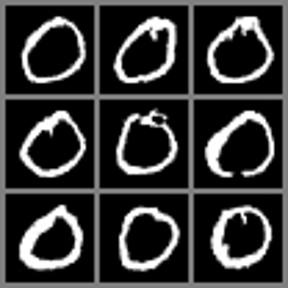

In [ ]:
model.eval()

num_samples = 9

c = mnist_encoder("0", num_samples)
noise = torch.randn(size=(num_samples,1,32,32)).to(device)
print(noise.shape)
print(type(c))
print(c.shape)
with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

torch.Size([9, 1, 32, 32])
<class 'torch.Tensor'>
torch.Size([9, 32])


  0%|          | 0/250 [00:00<?, ?it/s]

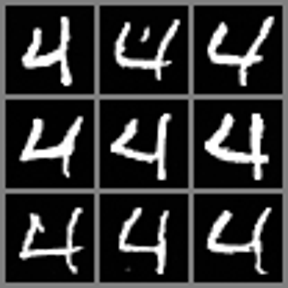

In [ ]:
model.eval()

num_samples = 9

c = mnist_encoder("4", num_samples)
noise = torch.randn(size=(num_samples,1,32,32)).to(device)
print(noise.shape)
print(type(c))
print(c.shape)
with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

torch.Size([9, 1, 32, 32])
<class 'torch.Tensor'>
torch.Size([9, 32])


  0%|          | 0/250 [00:00<?, ?it/s]

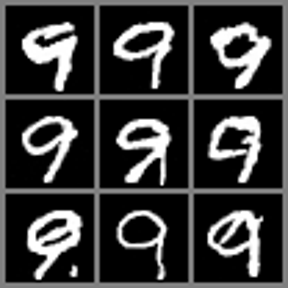

In [ ]:
model.eval()

num_samples = 9

c = mnist_encoder("9", num_samples)
noise = torch.randn(size=(num_samples,1,32,32)).to(device)
print(noise.shape)
print(type(c))
print(c.shape)
with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

## Generating mixes of digits
As an experiment, see what happens when we combine the embedding vectors for different digits.

In my experience, 4 and 9 are very easy to mix up, so let's embrace that.

torch.Size([9, 1, 32, 32])
<class 'torch.Tensor'>
torch.Size([9, 32])


  0%|          | 0/250 [00:00<?, ?it/s]

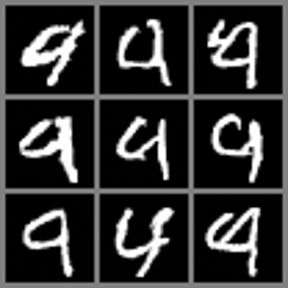

In [ ]:
model.eval()

num_samples = 9

c = 0.5 * mnist_encoder("4",num_samples) + 0.5 * mnist_encoder("9",num_samples)
noise = torch.randn(size=(num_samples,1,32,32)).to(device)
print(noise.shape)
print(type(c))
print(c.shape)
with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

Some of the above are clearly 9 or 4, but some are a little ambiguous, and at two of them appear to have features of both 4 and 9.

torch.Size([9, 1, 32, 32])
<class 'torch.Tensor'>
torch.Size([9, 32])


  0%|          | 0/250 [00:00<?, ?it/s]

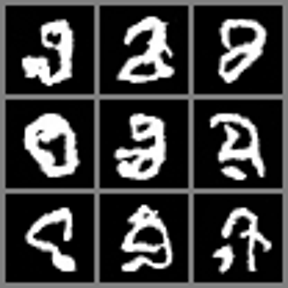

In [ ]:
model.eval()

num_samples = 9

c = 0.1 * mnist_encoder("0",num_samples) + 0.1 * mnist_encoder("1",num_samples) + 0.1 * mnist_encoder("2",num_samples)
c+= 0.1 * mnist_encoder("3",num_samples) + 0.1 * mnist_encoder("4",num_samples) + 0.1 * mnist_encoder("5",num_samples)
c+= 0.1 * mnist_encoder("6",num_samples) + 0.1 * mnist_encoder("7",num_samples) + 0.1 * mnist_encoder("8",num_samples)
c+= 0.1 * mnist_encoder("9",num_samples)
noise = torch.randn(size=(num_samples,1,32,32)).to(device)
print(noise.shape)
print(type(c))
print(c.shape)
with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))